# PROYECTO BIG  DATA 

Integrantes: Martín Jerez, Harold Vargas, Juliana Espinel y David Lopez 

### Pregunta de investigación

¿Cómo pueden detectarse patrones espacio-temporales de criminalidad en la ciudad de Los Ángeles mediante el análisis de grandes volúmenes de reportes, con el fin de anticipar zonas de riesgo y optimizar la toma de decisiones en seguridad pública?

### Objetivo

Analizar grandes volúmenes de reportes de criminalidad en la ciudad de Los Ángeles para detectar patrones espacio-temporales que permitan anticipar zonas de riesgo y fortalecer la toma de decisiones en materia de seguridad pública.

### Glosario

# Diccionario de Datos - Crime Dataset (LAPD)

| **Campo**       | **Descripción** | **Nombre en minúscula** | **Tipo de dato** |
|-----------------|-----------------|-------------------------|------------------|
| DR_NO           | Division of Records Number: Official file number made up of a 2 digit year, area ID, and 5 digits | `dr_no` | Text |
| Date Rptd       | Fecha en formato MM/DD/YYYY | `date_rptd` | Floating Timestamp |
| DATE OCC        | Fecha de ocurrencia en formato MM/DD/YYYY | `date_occ` | Floating Timestamp |
| TIME OCC        | En formato militar (24 horas) | `time_occ` | Text |
| AREA            | Número de área (1–21) correspondiente a una estación de policía LAPD | `area` | Text |
| AREA NAME       | Nombre de la estación/división de policía correspondiente al área | `area_name` | Text |
| Rpt Dist No     | Código de 4 dígitos que representa un sub-área dentro de un Área Geográfica | `rpt_dist_no` | Text |
| Part 1-2        | Clasificación del crimen (Parte 1 o 2) | `part_1_2` | Number |
| Crm Cd          | Código del crimen cometido (igual a Crime Code 1) | `crm_cd` | Text |
| Crm Cd Desc     | Descripción del código de crimen | `crm_cd_desc` | Text |
| Mocodes         | Modus Operandi: Actividades asociadas con el sospechoso [(lista de códigos MO)](https://data.lacity.org/api/views/y8tr-7khq/files/3a967fbd-f210-4857-bc52-60230efe256c?download=true&filename=MO%20CODES%20(numerical%20order).pdf) | `mocodes` | Text |
| Vict Age        | Edad de la víctima (número de 2 dígitos) | `vict_age` | Text |
| Vict Sex        | Sexo de la víctima: F = Femenino, M = Masculino, X = Desconocido | `vict_sex` | Text |
| Vict Descent    | Código de ascendencia/raza de la víctima (ej: B = Black, H = Hispanic, W = White, etc.) | `vict_descent` | Text |
| Premis Cd       | Código del tipo de estructura, vehículo o lugar donde ocurrió el crimen | `premis_cd` | Number |
| Premis Desc     | Descripción del código de premisa | `premis_desc` | Text |
| Weapon Used Cd  | Código del arma utilizada en el crimen | `weapon_used_cd` | Text |
| Weapon Desc     | Descripción del arma utilizada | `weapon_desc` | Text |
| Status          | Estado del caso (ej: IC = default) | `status` | Text |
| Status Desc     | Descripción del estado | `status_desc` | Text |
| Crm Cd 1        | Código del crimen principal (más serio) | `crm_cd_1` | Text |
| Crm Cd 2        | Código de crimen adicional (menos serio que Crm Cd 1) | `crm_cd_2` | Text |
| Crm Cd 3        | Código de crimen adicional (menos serio que Crm Cd 2) | `crm_cd_3` | Text |
| Crm Cd 4        | Código de crimen adicional (menos serio que Crm Cd 3) | `crm_cd_4` | Text |
| LOCATION        | Dirección aproximada del incidente (redondeada a la centena para anonimato) | `location` | Text |
| Cross Street    | Calle transversal de la dirección aproximada | `cross_street` | Text |
| LAT             | Latitud | `lat` | Number |
| LON             | Longitud | `lon` | Number |


## Conectar con mi contenedor 

In [3]:
#!/usr/bin/env python3
"""
Script completo para cargar datos de criminalidad LAPD desde Parquet a PostgreSQL
Incluye creación automática de tabla y carga de datos
Asegúrate de instalar las dependencias:
pip install pandas pyarrow psycopg2-binary sqlalchemy
"""

import pandas as pd
import psycopg2
from sqlalchemy import create_engine
import numpy as np
from datetime import datetime
import sys
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Configuración de la conexión a PostgreSQL
DB_CONFIG = {
    'host': 'localhost',
    'port': '5433',
    'database': 'BigdataFinal',
    'user': 'psqluser',
    'password': 'psqlpass'
}

# Ruta del archivo (cambia esta ruta por la tuya)
PARQUET_FILE_PATH = r"C:\Users\Davd Lopez\Documents\GitHub\ProjectBigData\Crime_Data_from_2020_to_Present.parquet"

def create_connection():
    """Crear conexión a PostgreSQL"""
    try:
        # Para psycopg2
        conn = psycopg2.connect(**DB_CONFIG)
        
        # Para SQLAlchemy
        engine = create_engine(
            f"postgresql://{DB_CONFIG['user']}:{DB_CONFIG['password']}@"
            f"{DB_CONFIG['host']}:{DB_CONFIG['port']}/{DB_CONFIG['database']}"
        )
        
        print("✅ Conexión exitosa a PostgreSQL")
        return conn, engine
        
    except Exception as e:
        print(f"❌ Error conectando a PostgreSQL: {e}")
        return None, None

def table_has_data(conn):
    """Verificar si la tabla lapd_crime_data tiene datos"""
    try:
        with conn.cursor() as cursor:
            cursor.execute("SELECT COUNT(*) FROM lapd_crime_data;")
            count = cursor.fetchone()[0]
            return count > 0
    except Exception as e:
        # Si hay algún error (como que la tabla no existe), asumimos que no hay datos
        print(f"⚠️  Error al verificar datos: {e}. Asumiendo que no hay datos.")
        return False

def create_table(conn):
    """Crear la tabla lapd_crime_data si no existe"""
    print("🏗️  Verificando si existe la tabla lapd_crime_data...")
    
    # Verificar si la tabla ya existe
    with conn.cursor() as cursor:
        cursor.execute("""
            SELECT EXISTS (
                SELECT FROM information_schema.tables 
                WHERE table_name = 'lapd_crime_data'
            );
        """)
        table_exists = cursor.fetchone()[0]
    
    if table_exists:
        print("✅ La tabla ya existe.")
        return True
    else:
        print("📋 La tabla no existe. Creándola...")
        create_table_sql = """
        CREATE TABLE lapd_crime_data (
            dr_no VARCHAR(20) PRIMARY KEY,
            date_rptd DATE,
            date_occ DATE,
            time_occ TIME,
            area VARCHAR(10),
            area_name VARCHAR(100),
            rpt_dist_no VARCHAR(10),
            part_1_2 INTEGER,
            crm_cd VARCHAR(10),
            crm_cd_desc VARCHAR(200),
            mocodes VARCHAR(100),
            vict_age VARCHAR(10),
            vict_sex CHAR(1),
            vict_descent CHAR(1),
            premis_cd INTEGER,
            premis_desc VARCHAR(200),
            weapon_used_cd VARCHAR(10),
            weapon_desc VARCHAR(200),
            status VARCHAR(10),
            status_desc VARCHAR(100),
            crm_cd_1 VARCHAR(10),
            crm_cd_2 VARCHAR(10),
            crm_cd_3 VARCHAR(10),
            crm_cd_4 VARCHAR(10),
            location VARCHAR(200),
            cross_street VARCHAR(200),
            lat DECIMAL(10, 8),
            lon DECIMAL(11, 8)
        );
        """
        try:
            with conn.cursor() as cursor:
                cursor.execute(create_table_sql)
            conn.commit()
            print("✅ Tabla creada exitosamente")
            
            # Ahora crear los índices
            create_index_sql = """
            CREATE INDEX idx_lapd_date_occ ON lapd_crime_data(date_occ);
            CREATE INDEX idx_lapd_area ON lapd_crime_data(area);
            CREATE INDEX idx_lapd_crm_cd ON lapd_crime_data(crm_cd);
            CREATE INDEX idx_lapd_location ON lapd_crime_data(lat, lon);
            CREATE INDEX idx_lapd_area_date ON lapd_crime_data(area, date_occ);
            """
            with conn.cursor() as cursor:
                cursor.execute(create_index_sql)
            conn.commit()
            print("✅ Índices creados exitosamente")
            return True
        except Exception as e:
            print(f"❌ Error creando tabla o índices: {e}")
            conn.rollback()
            return False

def clean_data(df):
    """Limpiar y preparar los datos"""
    print("🧹 Limpiando datos...")
    
    # Hacer una copia para no modificar el original
    df_clean = df.copy()
    
    # Mostrar las columnas originales
    print("📋 Columnas encontradas en el archivo:")
    for i, col in enumerate(df_clean.columns):
        print(f"  {i+1}. {col}")
    
    # Mapear nombres de columnas del archivo original a nombres de BD
    column_mapping = {
        'DR_NO': 'dr_no',
        'Date Rptd': 'date_rptd',
        'DATE OCC': 'date_occ', 
        'TIME OCC': 'time_occ',
        'AREA': 'area',
        'AREA NAME': 'area_name',
        'Rpt Dist No': 'rpt_dist_no',
        'Part 1-2': 'part_1_2',
        'Crm Cd': 'crm_cd',
        'Crm Cd Desc': 'crm_cd_desc',
        'Mocodes': 'mocodes',
        'Vict Age': 'vict_age',
        'Vict Sex': 'vict_sex',
        'Vict Descent': 'vict_descent',
        'Premis Cd': 'premis_cd',
        'Premis Desc': 'premis_desc',
        'Weapon Used Cd': 'weapon_used_cd',
        'Weapon Desc': 'weapon_desc',
        'Status': 'status',
        'Status Desc': 'status_desc',
        'Crm Cd 1': 'crm_cd_1',
        'Crm Cd 2': 'crm_cd_2',
        'Crm Cd 3': 'crm_cd_3',
        'Crm Cd 4': 'crm_cd_4',
        'LOCATION': 'location',
        'Cross Street': 'cross_street',
        'LAT': 'lat',
        'LON': 'lon'
    }
    
    # Renombrar columnas
    df_clean = df_clean.rename(columns=column_mapping)
    
    # Limpiar coordenadas inválidas (0, 0)
    if 'lat' in df_clean.columns and 'lon' in df_clean.columns:
        df_clean.loc[(df_clean['lat'] == 0) | (df_clean['lon'] == 0), ['lat', 'lon']] = np.nan
    
    # Convertir fechas
    date_columns = ['date_rptd', 'date_occ']
    for col in date_columns:
        if col in df_clean.columns:
            df_clean[col] = pd.to_datetime(df_clean[col], errors='coerce').dt.date
    
    # Limpiar tiempo
    if 'time_occ' in df_clean.columns:
        def format_time(time_val):
            if pd.isna(time_val):
                return None
            time_str = str(int(time_val)).zfill(4) if isinstance(time_val, (int, float)) else str(time_val).zfill(4)
            if len(time_str) >= 4:
                return f"{time_str[:2]}:{time_str[2:4]}"
            return None
        
        df_clean['time_occ'] = df_clean['time_occ'].apply(format_time)
    
    # Limpiar edad de víctima
    if 'vict_age' in df_clean.columns:
        df_clean['vict_age'] = df_clean['vict_age'].replace([0, -1], np.nan)
        df_clean['vict_age'] = df_clean['vict_age'].astype(str)
    
    # Truncar strings largos para evitar errores
    string_columns = {
        'area_name': 100,
        'crm_cd_desc': 200,
        'mocodes': 100,
        'premis_desc': 200,
        'weapon_desc': 200,
        'status_desc': 100,
        'location': 200,
        'cross_street': 200
    }
    
    for col, max_len in string_columns.items():
        if col in df_clean.columns:
            df_clean[col] = df_clean[col].astype(str).str[:max_len]
    
    # Asegurar que dr_no no tenga valores nulos
    if 'dr_no' in df_clean.columns:
        df_clean = df_clean.dropna(subset=['dr_no'])
        df_clean['dr_no'] = df_clean['dr_no'].astype(str)
    
    print(f"✅ Datos limpiados. Registros: {len(df_clean)}")
    return df_clean

def load_parquet_to_postgres(batch_size=10000):
    """Cargar archivo Parquet a PostgreSQL"""
    
    # Verificar que el archivo existe
    if not os.path.exists(PARQUET_FILE_PATH):
        print(f"❌ Archivo no encontrado: {PARQUET_FILE_PATH}")
        return False
    
    # Crear conexión
    conn, engine = create_connection()
    if not conn or not engine:
        return False
    
    try:
        # Crear tabla si no existe
        if not create_table(conn):
            print("❌ Falló la creación de la tabla. Abortando.")
            return False

        # Verificar si la tabla ya tiene datos
        if table_has_data(conn):
            print("✅ La tabla ya tiene datos. No se cargarán datos duplicados.")
            return True

        print(f"📁 Cargando archivo: {PARQUET_FILE_PATH}")
        
        # Leer el archivo Parquet
        print("📖 Leyendo archivo Parquet...")
        df = pd.read_parquet(PARQUET_FILE_PATH)
        
        print(f"📊 Dataset cargado: {len(df):,} registros, {len(df.columns)} columnas")
        print(f"📏 Tamaño en memoria: {df.memory_usage(deep=True).sum() / 1024 / 1024:.2f} MB")
        
        # Limpiar datos
        df_clean = clean_data(df)
        
        # Cargar datos en lotes
        print(f"💾 Cargando datos en lotes de {batch_size:,} registros...")
        
        total_batches = len(df_clean) // batch_size + (1 if len(df_clean) % batch_size > 0 else 0)
        loaded_records = 0
        
        for i, start_idx in enumerate(range(0, len(df_clean), batch_size)):
            end_idx = min(start_idx + batch_size, len(df_clean))
            batch_df = df_clean.iloc[start_idx:end_idx]
            
            try:
                # Cargar lote
                batch_df.to_sql(
                    'lapd_crime_data',
                    engine,
                    if_exists='append',
                    index=False,
                    method='multi'
                )
                
                loaded_records += len(batch_df)
                progress = ((i + 1) / total_batches) * 100
                print(f"📈 Progreso: {progress:.1f}% - Lote {i+1}/{total_batches} - Registros cargados: {loaded_records:,}")
                
            except Exception as e:
                print(f"⚠️  Error en lote {i+1}: {e}")
                continue
        
        print("✅ Datos cargados exitosamente!")
        
        # Verificar carga
        with conn.cursor() as cursor:
            cursor.execute("SELECT COUNT(*) FROM lapd_crime_data;")
            count = cursor.fetchone()[0]
            print(f"📊 Total de registros en la base de datos: {count:,}")
            
            # Mostrar algunas estadísticas
            cursor.execute("""
                SELECT 
                    MIN(date_occ) as fecha_min,
                    MAX(date_occ) as fecha_max,
                    COUNT(DISTINCT area) as areas_distintas,
                    COUNT(DISTINCT crm_cd) as tipos_crimen
                FROM lapd_crime_data;
            """)
            stats = cursor.fetchone()
            print(f"📈 Estadísticas:")
            print(f"  - Rango de fechas: {stats[0]} a {stats[1]}")
            print(f"  - Áreas distintas: {stats[2]}")
            print(f"  - Tipos de crimen distintos: {stats[3]}")
        
        return True
        
    except Exception as e:
        print(f"❌ Error cargando datos: {e}")
        import traceback
        traceback.print_exc()
        return False
        
    finally:
        if conn:
            conn.close()
        if engine:
            engine.dispose()

def main():
    """Función principal"""
    print("🚀 Iniciando carga de datos LAPD desde Parquet a PostgreSQL")
    print(f"📁 Archivo: {PARQUET_FILE_PATH}")
    print("="*80)
    
    # Verificar conexión con Docker
    print("🔍 Verificando conexión a PostgreSQL...")
    
    success = load_parquet_to_postgres(batch_size=5000)  # Lotes más pequeños por seguridad
    
    if success:
        print("\n🎉 ¡Carga completada exitosamente!")
        print("\nPuedes conectarte a la base de datos y hacer consultas:")
        print("docker exec -it postgres16_bigdata psql -U psqluser -d BigdataFinal")
    else:
        print("\n❌ La carga falló. Revisa los errores anteriores.")

if __name__ == "__main__":
    main()

🚀 Iniciando carga de datos LAPD desde Parquet a PostgreSQL
📁 Archivo: C:\Users\Davd Lopez\Documents\GitHub\ProjectBigData\Crime_Data_from_2020_to_Present.parquet
🔍 Verificando conexión a PostgreSQL...
✅ Conexión exitosa a PostgreSQL
🏗️  Verificando si existe la tabla lapd_crime_data...
✅ La tabla ya existe.
✅ La tabla ya tiene datos. No se cargarán datos duplicados.

🎉 ¡Carga completada exitosamente!

Puedes conectarte a la base de datos y hacer consultas:
docker exec -it postgres16_bigdata psql -U psqluser -d BigdataFinal


## Missing values 

🔍 Iniciando análisis de missing values en la tabla lapd_crime_data
✅ Conexión exitosa a PostgreSQL
📊 Total de registros en la tabla: 1,004,991

🔍 Analizando missing values...

ANÁLISIS DE VALORES FALTANTES
crm_cd_4             | 1,004,927 |  99.99% | (NULL: 1,004,927, Especial: 0)
crm_cd_3             | 1,002,677 |  99.77% | (NULL: 1,002,677, Especial: 0)
crm_cd_2             |  935,831 |  93.12% | (NULL: 935,831, Especial: 0)
weapon_used_cd       |  677,744 |  67.44% | (NULL: 677,744, Especial: 0)
vict_age             |  269,322 |  26.80% | (NULL: 0, Especial: 269,322)
vict_descent         |  144,656 |  14.39% | (NULL: 144,656, Especial: 0)
vict_sex             |  144,644 |  14.39% | (NULL: 144,644, Especial: 0)
lon                  |    2,240 |   0.22% | (NULL: 0, Especial: 2,240)
lat                  |    2,240 |   0.22% | (NULL: 0, Especial: 2,240)
premis_cd            |       16 |   0.00% | (NULL: 16, Especial: 0)
crm_cd_1             |       11 |   0.00% | (NULL: 11, Especial: 0)

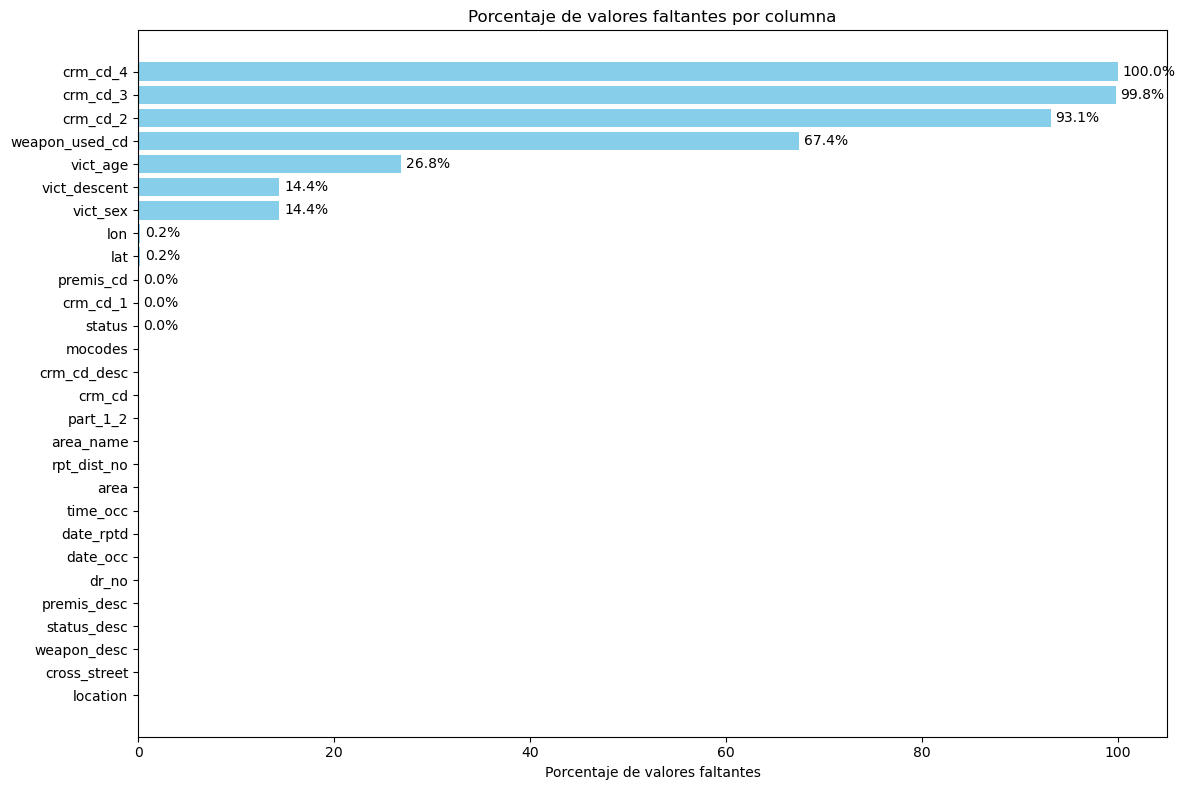

In [4]:
#!/usr/bin/env python3
"""
Script para analizar missing values en la tabla lapd_crime_data de PostgreSQL
"""

# Configuración de la conexión a PostgreSQL
DB_CONFIG = {
    'host': 'localhost',
    'port': '5433',
    'database': 'BigdataFinal',
    'user': 'psqluser',
    'password': 'psqlpass'
}

def create_connection():
    """Crear conexión a PostgreSQL"""
    try:
        conn = psycopg2.connect(**DB_CONFIG)
        print("✅ Conexión exitosa a PostgreSQL")
        return conn
    except Exception as e:
        print(f"❌ Error conectando a PostgreSQL: {e}")
        return None

def analyze_missing_values():
    """Analizar missing values en la tabla lapd_crime_data"""
    conn = create_connection()
    if not conn:
        return
    
    try:
        # Obtener el total de registros
        with conn.cursor() as cursor:
            cursor.execute("SELECT COUNT(*) FROM lapd_crime_data;")
            total_records = cursor.fetchone()[0]
            print(f"📊 Total de registros en la tabla: {total_records:,}")
        
        # Obtener la lista de columnas
        with conn.cursor() as cursor:
            cursor.execute("""
                SELECT column_name 
                FROM information_schema.columns 
                WHERE table_name = 'lapd_crime_data'
                ORDER BY ordinal_position;
            """)
            columns = [row[0] for row in cursor.fetchall()]
        
        print("\n🔍 Analizando missing values...")
        
        # Analizar cada columna
        results = []
        for column in columns:
            with conn.cursor() as cursor:
                # Contar valores NULL
                cursor.execute(f"SELECT COUNT(*) FROM lapd_crime_data WHERE {column} IS NULL;")
                null_count = cursor.fetchone()[0]
                
                # Para columnas específicas, verificar valores que representan missing values
                special_missing = 0
                if column in ['lat', 'lon']:
                    cursor.execute(f"SELECT COUNT(*) FROM lapd_crime_data WHERE {column} = 0;")
                    special_missing = cursor.fetchone()[0]
                elif column == 'vict_age':
                    cursor.execute(f"SELECT COUNT(*) FROM lapd_crime_data WHERE {column} IN ('0', '-1', 'NaN');")
                    special_missing = cursor.fetchone()[0]
                
                total_missing = null_count + special_missing
                missing_percentage = (total_missing / total_records) * 100
                
                results.append({
                    'column': column,
                    'null_count': null_count,
                    'special_missing': special_missing,
                    'total_missing': total_missing,
                    'missing_percentage': missing_percentage
                })
        
        # Crear DataFrame con los resultados
        df_results = pd.DataFrame(results)
        df_results = df_results.sort_values('missing_percentage', ascending=False)
        
        # Mostrar resultados
        print("\n" + "="*80)
        print("ANÁLISIS DE VALORES FALTANTES")
        print("="*80)
        for _, row in df_results.iterrows():
            print(f"{row['column']:20} | {row['total_missing']:>8,} | {row['missing_percentage']:>6.2f}% | "
                  f"(NULL: {row['null_count']:,}, Especial: {row['special_missing']:,})")
        
        # Visualizar resultados
        plt.figure(figsize=(12, 8))
        bars = plt.barh(df_results['column'], df_results['missing_percentage'], color='skyblue')
        plt.xlabel('Porcentaje de valores faltantes')
        plt.title('Porcentaje de valores faltantes por columna')
        plt.gca().invert_yaxis()  # Mostrar la columna con mayor porcentaje en la parte superior
        
        # Añadir etiquetas de valor en las barras
        for bar, percentage in zip(bars, df_results['missing_percentage']):
            if percentage > 0:
                plt.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2, 
                        f'{percentage:.1f}%', ha='left', va='center')
        
        plt.tight_layout()
        plt.savefig('missing_values_analysis.png', dpi=300, bbox_inches='tight')
        print("\n📈 Gráfico guardado como 'missing_values_analysis.png'")
        
        # Mostrar estadísticas resumidas
        print("\n" + "="*80)
        print("ESTADÍSTICAS RESUMEN")
        print("="*80)
        print(f"Total de registros: {total_records:,}")
        print(f"Columnas con más del 50% de valores faltantes: {len(df_results[df_results['missing_percentage'] > 50])}")
        print(f"Columnas con menos del 5% de valores faltantes: {len(df_results[df_results['missing_percentage'] < 5])}")
        
        # Mostrar las 5 columnas con más valores faltantes
        print("\nTop 5 columnas con más valores faltantes:")
        top5 = df_results.head()
        for _, row in top5.iterrows():
            print(f"  - {row['column']}: {row['missing_percentage']:.2f}%")
        
        # Guardar resultados en CSV
        df_results.to_csv('missing_values_analysis.csv', index=False)
        print("\n📊 Resultados detallados guardados en 'missing_values_analysis.csv'")
        
    except Exception as e:
        print(f"❌ Error analizando missing values: {e}")
        import traceback
        traceback.print_exc()
    
    finally:
        if conn:
            conn.close()

def main():
    """Función principal"""
    print("🔍 Iniciando análisis de missing values en la tabla lapd_crime_data")
    print("="*80)
    analyze_missing_values()

if __name__ == "__main__":
    main()

In [7]:
#!/usr/bin/env python3
"""
Script para limpieza de datos en la tabla lapd_crime_data - Versión corregida
- Eliminar columnas con muchos nulos
- Eliminar filas con nulos en columnas clave y valores especiales (0 en coordenadas)
- Imputar valores para vict_age, vict_sex, vict_descent
"""

import psycopg2
import pandas as pd
import numpy as np

# Configuración de la conexión a PostgreSQL
DB_CONFIG = {
    'host': 'localhost',
    'port': '5433',
    'database': 'BigdataFinal',
    'user': 'psqluser',
    'password': 'psqlpass'
}

def create_connection():
    """Crear conexión a PostgreSQL"""
    try:
        conn = psycopg2.connect(**DB_CONFIG)
        print("✅ Conexión exitosa a PostgreSQL")
        return conn
    except Exception as e:
        print(f"❌ Error conectando a PostgreSQL: {e}")
        return None

def drop_columns(conn):
    """Eliminar columnas con muchos valores nulos"""
    print("🗑️  Eliminando columnas con muchos nulos...")
    try:
        with conn.cursor() as cursor:
            # Verificar si las columnas existen antes de eliminarlas
            cursor.execute("""
                SELECT column_name 
                FROM information_schema.columns 
                WHERE table_name = 'lapd_crime_data' 
                AND column_name IN ('crm_cd_2', 'crm_cd_3', 'crm_cd_4', 'weapon_used_cd', 'weapon_desc');
            """)
            existing_columns = [row[0] for row in cursor.fetchall()]
            
            if existing_columns:
                drop_columns_sql = "ALTER TABLE lapd_crime_data "
                drop_columns_sql += ", ".join([f"DROP COLUMN {col}" for col in existing_columns])
                cursor.execute(drop_columns_sql)
                print(f"✅ Columnas eliminadas: {existing_columns}")
            else:
                print("✅ No hay columnas para eliminar")
        conn.commit()
    except Exception as e:
        print(f"❌ Error eliminando columnas: {e}")
        conn.rollback()

def clean_special_values(conn):
    """Limpiar valores especiales (0 en coordenadas, valores inválidos en vict_age)"""
    print("🧹 Limpiando valores especiales...")
    try:
        with conn.cursor() as cursor:
            # 1. Para lat y lon: convertir 0 a NULL
            cursor.execute("""
                UPDATE lapd_crime_data 
                SET lat = NULL 
                WHERE lat = 0;
            """)
            lat_updated = cursor.rowcount
            cursor.execute("""
                UPDATE lapd_crime_data 
                SET lon = NULL 
                WHERE lon = 0;
            """)
            lon_updated = cursor.rowcount
            print(f"✅ Coordenadas 0 convertidas a NULL: lat={lat_updated}, lon={lon_updated}")

            # 2. Para vict_age: convertir valores no numéricos y edades inválidas a NULL
            cursor.execute("""
                UPDATE lapd_crime_data 
                SET vict_age = NULL 
                WHERE vict_age IS NOT NULL AND (
                    vict_age !~ '^[0-9]+$' OR 
                    vict_age::integer <= 0 OR 
                    vict_age::integer > 120
                );
            """)
            vict_age_updated = cursor.rowcount
            print(f"✅ Valores inválidos en vict_age convertidos a NULL: {vict_age_updated}")

        conn.commit()
    except Exception as e:
        print(f"❌ Error limpiando valores especiales: {e}")
        conn.rollback()

def delete_rows_with_nulls(conn):
    """Eliminar filas con valores nulos en columnas clave"""
    print("🧹 Eliminando filas con nulos en columnas clave...")
    try:
        with conn.cursor() as cursor:
            cursor.execute("""
                DELETE FROM lapd_crime_data 
                WHERE lon IS NULL 
                OR lat IS NULL 
                OR premis_cd IS NULL 
                OR crm_cd_1 IS NULL 
                OR status IS NULL;
            """)
            deleted_rows = cursor.rowcount
            conn.commit()
            print(f"✅ Filas eliminadas: {deleted_rows}")
    except Exception as e:
        print(f"❌ Error eliminando filas: {e}")
        conn.rollback()

def impute_vict_sex(conn):
    """Imputar valores missing para vict_sex con la moda"""
    print("🔧 Imputando vict_sex...")
    try:
        with conn.cursor() as cursor:
            # Obtener la moda (valor más frecuente)
            cursor.execute("""
                SELECT vict_sex, COUNT(*) as count 
                FROM lapd_crime_data 
                WHERE vict_sex IS NOT NULL AND vict_sex != 'nan'
                GROUP BY vict_sex 
                ORDER BY count DESC 
                LIMIT 1;
            """)
            mode = cursor.fetchone()
            if mode:
                mode_value = mode[0]
                print(f"Moda para vict_sex: {mode_value}")
                # Actualizar los valores missing
                cursor.execute("""
                    UPDATE lapd_crime_data 
                    SET vict_sex = %s
                    WHERE vict_sex IS NULL OR vict_sex = 'nan';
                """, (mode_value,))
                updated_rows = cursor.rowcount
                conn.commit()
                print(f"✅ vict_sex imputado. Filas actualizadas: {updated_rows}")
            else:
                print("⚠️  No se encontró moda para vict_sex")
    except Exception as e:
        print(f"❌ Error imputando vict_sex: {e}")
        conn.rollback()

def impute_vict_descent(conn):
    """Imputar valores missing para vict_descent con la moda"""
    print("🔧 Imputando vict_descent...")
    try:
        with conn.cursor() as cursor:
            # Obtener la moda
            cursor.execute("""
                SELECT vict_descent, COUNT(*) as count 
                FROM lapd_crime_data 
                WHERE vict_descent IS NOT NULL AND vict_descent != 'nan'
                GROUP BY vict_descent 
                ORDER BY count DESC 
                LIMIT 1;
            """)
            mode = cursor.fetchone()
            if mode:
                mode_value = mode[0]
                print(f"Moda para vict_descent: {mode_value}")
                # Actualizar los valores missing
                cursor.execute("""
                    UPDATE lapd_crime_data 
                    SET vict_descent = %s
                    WHERE vict_descent IS NULL OR vict_descent = 'nan';
                """, (mode_value,))
                updated_rows = cursor.rowcount
                conn.commit()
                print(f"✅ vict_descent imputado. Filas actualizadas: {updated_rows}")
            else:
                print("⚠️  No se encontró moda para vict_descent")
    except Exception as e:
        print(f"❌ Error imputando vict_descent: {e}")
        conn.rollback()

def impute_vict_age(conn):
    """Imputar valores missing para vict_age con la mediana"""
    print("🔧 Imputando vict_age...")
    try:
        with conn.cursor() as cursor:
            # Calcular la mediana
            cursor.execute("""
                SELECT PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY vict_age::numeric) 
                FROM lapd_crime_data 
                WHERE vict_age IS NOT NULL;
            """)
            median = cursor.fetchone()[0]
            if median:
                median_value = int(median)  # La mediana puede ser float, pero la edad es entera
                print(f"Mediana para vict_age: {median_value}")
                # Actualizar los valores NULL
                cursor.execute("""
                    UPDATE lapd_crime_data 
                    SET vict_age = %s
                    WHERE vict_age IS NULL;
                """, (str(median_value),))  # Guardar como string
                updated_rows = cursor.rowcount
                conn.commit()
                print(f"✅ vict_age imputado. Filas actualizadas: {updated_rows}")
            else:
                print("⚠️  No se pudo calcular la mediana para vict_age")
    except Exception as e:
        print(f"❌ Error imputando vict_age: {e}")
        conn.rollback()

def main():
    """Función principal"""
    print("🚀 Iniciando limpieza de datos en la tabla lapd_crime_data")
    print("="*80)
    
    conn = create_connection()
    if not conn:
        return
    
    try:
        # Paso 0: Limpiar valores especiales (0 en coordenadas, valores inválidos en vict_age)
        clean_special_values(conn)
        
        # Paso 1: Eliminar columnas
        drop_columns(conn)
        
        # Paso 2: Eliminar filas con nulos en columnas clave
        delete_rows_with_nulls(conn)
        
        # Paso 3: Imputar valores
        impute_vict_sex(conn)
        impute_vict_descent(conn)
        impute_vict_age(conn)
        
        print("🎉 Limpieza completada exitosamente!")
        
    except Exception as e:
        print(f"❌ Error durante la limpieza: {e}")
    finally:
        if conn:
            conn.close()

if __name__ == "__main__":
    main()

🚀 Iniciando limpieza de datos en la tabla lapd_crime_data
✅ Conexión exitosa a PostgreSQL
🧹 Limpiando valores especiales...
✅ Coordenadas 0 convertidas a NULL: lat=2240, lon=2240
✅ Valores inválidos en vict_age convertidos a NULL: 269202
🗑️  Eliminando columnas con muchos nulos...
✅ No hay columnas para eliminar
🧹 Eliminando filas con nulos en columnas clave...
✅ Filas eliminadas: 2240
🔧 Imputando vict_sex...
Moda para vict_sex: M
✅ vict_sex imputado. Filas actualizadas: 0
🔧 Imputando vict_descent...
Moda para vict_descent: H
✅ vict_descent imputado. Filas actualizadas: 0
🔧 Imputando vict_age...
Mediana para vict_age: 37
✅ vict_age imputado. Filas actualizadas: 268654
🎉 Limpieza completada exitosamente!


🔍 Iniciando análisis de missing values en la tabla lapd_crime_data
✅ Conexión exitosa a PostgreSQL
📊 Total de registros en la tabla: 1,002,724

🔍 Analizando missing values...

ANÁLISIS DE VALORES FALTANTES
dr_no                |        0 |   0.00% | (NULL: 0, Especial: 0)
date_rptd            |        0 |   0.00% | (NULL: 0, Especial: 0)
date_occ             |        0 |   0.00% | (NULL: 0, Especial: 0)
time_occ             |        0 |   0.00% | (NULL: 0, Especial: 0)
area                 |        0 |   0.00% | (NULL: 0, Especial: 0)
area_name            |        0 |   0.00% | (NULL: 0, Especial: 0)
rpt_dist_no          |        0 |   0.00% | (NULL: 0, Especial: 0)
part_1_2             |        0 |   0.00% | (NULL: 0, Especial: 0)
crm_cd               |        0 |   0.00% | (NULL: 0, Especial: 0)
crm_cd_desc          |        0 |   0.00% | (NULL: 0, Especial: 0)
mocodes              |        0 |   0.00% | (NULL: 0, Especial: 0)
vict_age             |        0 |   0.00% | (NULL: 0, Esp

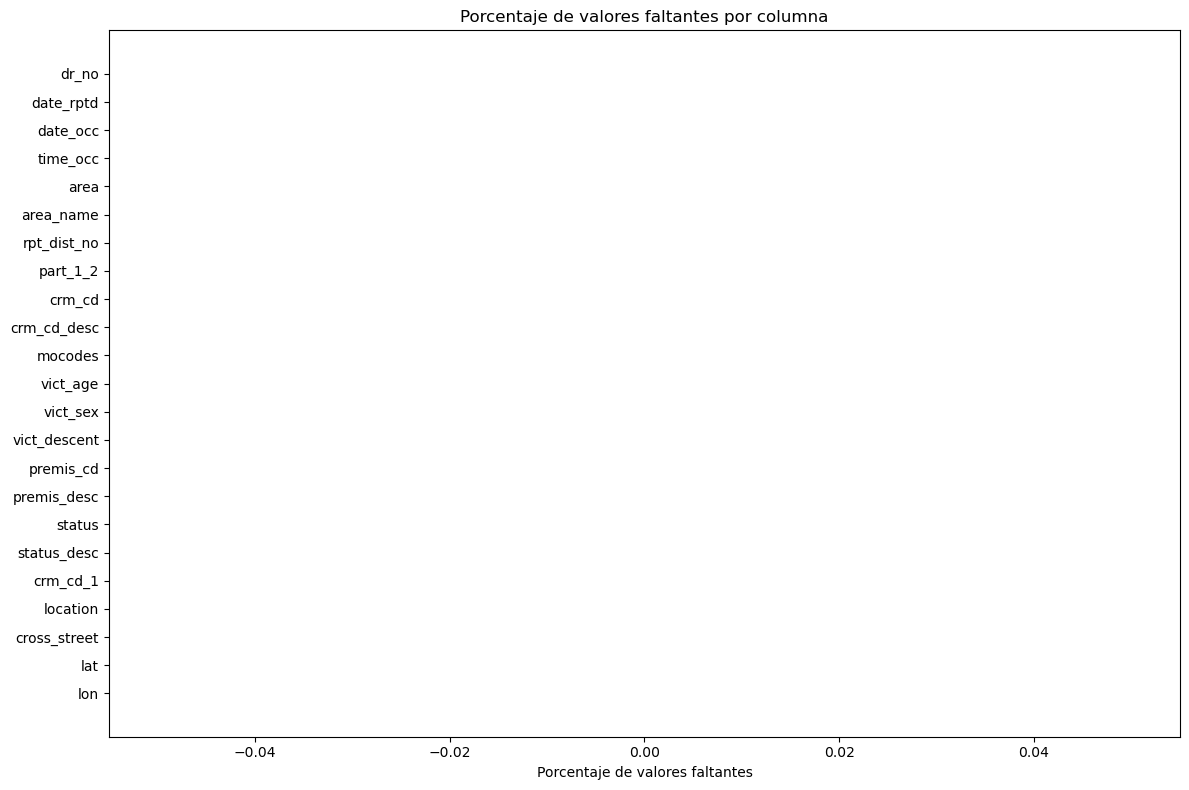

In [8]:
#!/usr/bin/env python3
"""
Script para analizar missing values en la tabla lapd_crime_data de PostgreSQL
"""

# Configuración de la conexión a PostgreSQL
DB_CONFIG = {
    'host': 'localhost',
    'port': '5433',
    'database': 'BigdataFinal',
    'user': 'psqluser',
    'password': 'psqlpass'
}

def create_connection():
    """Crear conexión a PostgreSQL"""
    try:
        conn = psycopg2.connect(**DB_CONFIG)
        print("✅ Conexión exitosa a PostgreSQL")
        return conn
    except Exception as e:
        print(f"❌ Error conectando a PostgreSQL: {e}")
        return None

def analyze_missing_values():
    """Analizar missing values en la tabla lapd_crime_data"""
    conn = create_connection()
    if not conn:
        return
    
    try:
        # Obtener el total de registros
        with conn.cursor() as cursor:
            cursor.execute("SELECT COUNT(*) FROM lapd_crime_data;")
            total_records = cursor.fetchone()[0]
            print(f"📊 Total de registros en la tabla: {total_records:,}")
        
        # Obtener la lista de columnas
        with conn.cursor() as cursor:
            cursor.execute("""
                SELECT column_name 
                FROM information_schema.columns 
                WHERE table_name = 'lapd_crime_data'
                ORDER BY ordinal_position;
            """)
            columns = [row[0] for row in cursor.fetchall()]
        
        print("\n🔍 Analizando missing values...")
        
        # Analizar cada columna
        results = []
        for column in columns:
            with conn.cursor() as cursor:
                # Contar valores NULL
                cursor.execute(f"SELECT COUNT(*) FROM lapd_crime_data WHERE {column} IS NULL;")
                null_count = cursor.fetchone()[0]
                
                # Para columnas específicas, verificar valores que representan missing values
                special_missing = 0
                if column in ['lat', 'lon']:
                    cursor.execute(f"SELECT COUNT(*) FROM lapd_crime_data WHERE {column} = 0;")
                    special_missing = cursor.fetchone()[0]
                elif column == 'vict_age':
                    cursor.execute(f"SELECT COUNT(*) FROM lapd_crime_data WHERE {column} IN ('0', '-1', 'NaN');")
                    special_missing = cursor.fetchone()[0]
                
                total_missing = null_count + special_missing
                missing_percentage = (total_missing / total_records) * 100
                
                results.append({
                    'column': column,
                    'null_count': null_count,
                    'special_missing': special_missing,
                    'total_missing': total_missing,
                    'missing_percentage': missing_percentage
                })
        
        # Crear DataFrame con los resultados
        df_results = pd.DataFrame(results)
        df_results = df_results.sort_values('missing_percentage', ascending=False)
        
        # Mostrar resultados
        print("\n" + "="*80)
        print("ANÁLISIS DE VALORES FALTANTES")
        print("="*80)
        for _, row in df_results.iterrows():
            print(f"{row['column']:20} | {row['total_missing']:>8,} | {row['missing_percentage']:>6.2f}% | "
                  f"(NULL: {row['null_count']:,}, Especial: {row['special_missing']:,})")
        
        # Visualizar resultados
        plt.figure(figsize=(12, 8))
        bars = plt.barh(df_results['column'], df_results['missing_percentage'], color='skyblue')
        plt.xlabel('Porcentaje de valores faltantes')
        plt.title('Porcentaje de valores faltantes por columna')
        plt.gca().invert_yaxis()  # Mostrar la columna con mayor porcentaje en la parte superior
        
        # Añadir etiquetas de valor en las barras
        for bar, percentage in zip(bars, df_results['missing_percentage']):
            if percentage > 0:
                plt.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2, 
                        f'{percentage:.1f}%', ha='left', va='center')
        
        plt.tight_layout()
        plt.savefig('missing_values_analysis.png', dpi=300, bbox_inches='tight')
        print("\n📈 Gráfico guardado como 'missing_values_analysis.png'")
        
        # Mostrar estadísticas resumidas
        print("\n" + "="*80)
        print("ESTADÍSTICAS RESUMEN")
        print("="*80)
        print(f"Total de registros: {total_records:,}")
        print(f"Columnas con más del 50% de valores faltantes: {len(df_results[df_results['missing_percentage'] > 50])}")
        print(f"Columnas con menos del 5% de valores faltantes: {len(df_results[df_results['missing_percentage'] < 5])}")
        
        # Mostrar las 5 columnas con más valores faltantes
        print("\nTop 5 columnas con más valores faltantes:")
        top5 = df_results.head()
        for _, row in top5.iterrows():
            print(f"  - {row['column']}: {row['missing_percentage']:.2f}%")
        
        # Guardar resultados en CSV
        df_results.to_csv('missing_values_analysis.csv', index=False)
        print("\n📊 Resultados detallados guardados en 'missing_values_analysis.csv'")
        
    except Exception as e:
        print(f"❌ Error analizando missing values: {e}")
        import traceback
        traceback.print_exc()
    
    finally:
        if conn:
            conn.close()

def main():
    """Función principal"""
    print("🔍 Iniciando análisis de missing values en la tabla lapd_crime_data")
    print("="*80)
    analyze_missing_values()

if __name__ == "__main__":
    main()